In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

In [244]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

### Load dataset

In [145]:
data = pd.read_csv("data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   index                              984 non-null    int64  
 1   link                               984 non-null    object 
 2   name                               984 non-null    object 
 3   user rating                        690 non-null    float64
 4   Price (in Indian Rupees)           984 non-null    int64  
 5   Type                               984 non-null    int64  
 6   Dedicated Graphic Memory Capacity  984 non-null    float64
 7   Processor Brand                    984 non-null    int64  
 8   SSD                                984 non-null    int64  
 9   RAM (in GB)                        984 non-null    int64  
 10  RAM Type                           984 non-null    object 
 11  Expandable Memory                  984 non-null    int64  

In [5]:
print(f"Number of missing values in dataset:\n{data.isna().sum()}")

Number of missing values in dataset:
index                                  0
link                                   0
name                                   0
user rating                          294
Price (in Indian Rupees)               0
Type                                   0
Dedicated Graphic Memory Capacity      0
Processor Brand                        0
SSD                                    0
RAM (in GB)                            0
RAM Type                               0
Expandable Memory                      0
Operating System                       0
Touchscreen                            0
Screen Size (in inch)                  0
Weight (in kg)                         0
Refresh Rate                           0
screen_resolution                      0
company                                0
Storage                                0
Processor name                         0
CPU_ranking                            0
battery_backup                         0
gpu name            

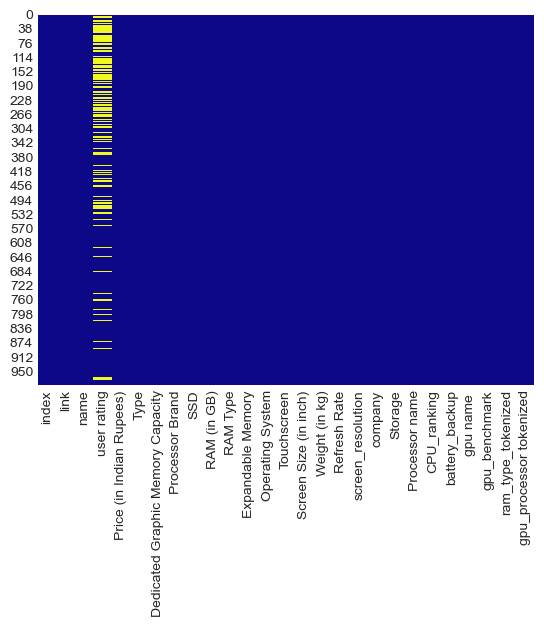

In [6]:
sns.heatmap(data.isna(), cbar=False, cmap='plasma')
plt.show()

In [7]:
print(data[:5][:].to_string())

   index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         link                                                                                                                                                                                                             name  user rating  Price (in Indian Rupees)  Type  Dedicated Graphic Memory Capacity  Processor Brand  SSD  RAM (in GB) RAM Type  Expandable Memory  Operating System  Touchscreen  Screen Size (in inch)  Weight (in kg)  Refresh Rate  screen_resolution  company  Storage          

In [146]:
data.drop(["index"], axis=1, inplace=True)

In [9]:
print(f"Number of duplicates in dataset: {data.duplicated().sum()}")

Number of duplicates in dataset: 0


In [147]:
data.drop(["link", "name", "ram_type_tokenized", "gpu_processor tokenized"], axis=1, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user rating                        690 non-null    float64
 1   Price (in Indian Rupees)           984 non-null    int64  
 2   Type                               984 non-null    int64  
 3   Dedicated Graphic Memory Capacity  984 non-null    float64
 4   Processor Brand                    984 non-null    int64  
 5   SSD                                984 non-null    int64  
 6   RAM (in GB)                        984 non-null    int64  
 7   RAM Type                           984 non-null    object 
 8   Expandable Memory                  984 non-null    int64  
 9   Operating System                   984 non-null    int64  
 10  Touchscreen                        984 non-null    int64  
 11  Screen Size (in inch)              984 non-null    float64

### Explore features

In [148]:
numerical_features = ["user rating", "Price (in Indian Rupees)", "Dedicated Graphic Memory Capacity", "RAM (in GB)",
                      "Screen Size (in inch)", "Weight (in kg)", "Refresh Rate", "screen_resolution", "Storage", "CPU_ranking",
                      "battery_backup", "gpu_benchmark"]
binary_features = ["SSD", "Expandable Memory", "Touchscreen"]
already_encoded_categorical_features = ["Type", "Processor Brand", "Operating System", "company"]
categorical_features = ["RAM Type", "Processor name", "gpu name "]

In [13]:
data[numerical_features].describe()

user rating  Price (in Indian Rupees)  \
count   690.000000                984.000000   
mean      4.206232              69849.695122   
std       0.446992              38694.092347   
min       1.800000              15990.000000   
25%       4.000000              43475.000000   
50%       4.300000              59990.000000   
75%       4.500000              82461.750000   
max       5.000000             301990.000000   

       Dedicated Graphic Memory Capacity  RAM (in GB)  Screen Size (in inch)  \
count                         984.000000   984.000000             984.000000   
mean                            1.328016    10.422764              14.838252   
std                             2.232855     4.955974               1.018683   
min                             0.000000     4.000000              11.600000   
25%                             0.000000     8.000000              14.000000   
50%                             0.000000     8.000000              15.600000   
75%                             4.000000    16.000000              15.600000   
max                            16.000000    32.000000              17.300000   

       Weight (in kg)  Refresh Rate  screen_resolution      Storage  \
count      984.000000    984.000000         984.000000   984.000000   
mean         1.679041     50.873984        1093.170732   648.638211   
std          0.402846     20.978853         192.368403   331.317760   
min          0.780000      1.000000         720.000000    32.000000   
25%          1.400000     60.000000        1080.000000   512.000000   
50%          1.650000     60.000000        1080.000000   512.000000   
75%          1.850000     60.000000        1080.000000  1000.000000   
max          2.900000     60.000000        2160.000000  2000.000000   

       CPU_ranking  battery_backup  gpu_benchmark  
count   984.000000      984.000000     984.000000  
mean    230.639228        4.414634      40.685955  
std     209.577002        0.260739      42.637175  
min       4.000000        4.000000       1.000000  
25%      87.000000        4.500000       5.050000  
50%     108.000000        4.500000      17.500000  
75%     362.000000        4.500000      72.600000  
max     907.000000        5.000000     233.000000

In [23]:
data[numerical_features].skew()

user rating                         -1.572152
Price (in Indian Rupees)             2.153679
Dedicated Graphic Memory Capacity    1.837435
RAM (in GB)                          1.404920
Screen Size (in inch)               -0.513913
Weight (in kg)                       0.397602
Refresh Rate                        -1.871010
screen_resolution                    2.118822
Storage                              0.690955
CPU_ranking                          1.232533
battery_backup                      -0.188219
gpu_benchmark                        1.031559
dtype: float64

In [24]:
data[numerical_features].mode()

user rating  Price (in Indian Rupees)  Dedicated Graphic Memory Capacity  \
0          4.3                     40990                                0.0   

   RAM (in GB)  Screen Size (in inch)  Weight (in kg)  Refresh Rate  \
0            8                   15.6             1.8            60   

   screen_resolution  Storage  CPU_ranking  battery_backup  gpu_benchmark  
0               1080      512          108             4.5           5.05

In [20]:
for i, feature in enumerate(numerical_features):
    unique_values = data[feature].unique()
    print(f"{feature}: {len(unique_values)} unique values")

user rating: 29 unique values
Price (in Indian Rupees): 433 unique values
Dedicated Graphic Memory Capacity: 10 unique values
RAM (in GB): 4 unique values
Screen Size (in inch): 21 unique values
Weight (in kg): 99 unique values
Refresh Rate: 6 unique values
screen_resolution: 4 unique values
Storage: 11 unique values
CPU_ranking: 48 unique values
battery_backup: 3 unique values
gpu_benchmark: 49 unique values


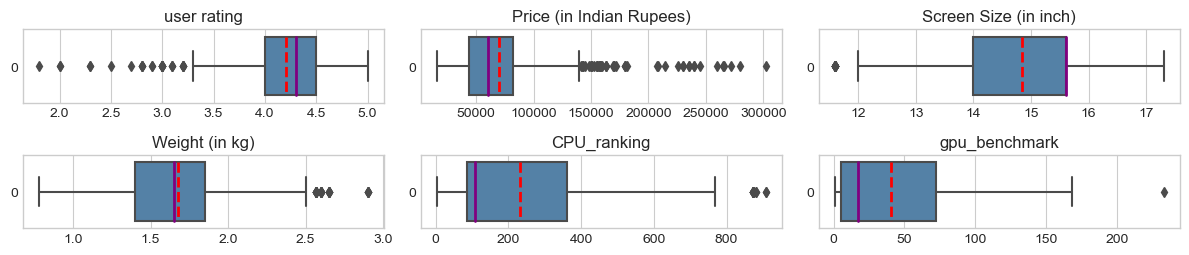

In [21]:
plt.figure(figsize=(12, 5))

for i, feature in enumerate(["user rating", "Price (in Indian Rupees)", "Screen Size (in inch)", "Weight (in kg)", "CPU_ranking", "gpu_benchmark"]):
    plt.subplot(4, 3, i+1)
    plt.title(feature)
    sns.boxplot(data[feature], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})

plt.tight_layout()

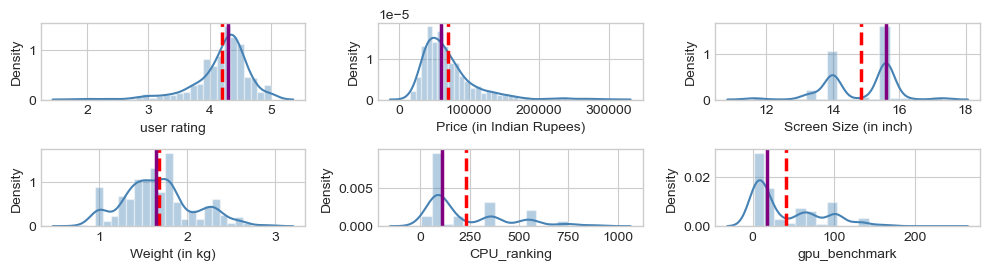

In [22]:
plt.figure(figsize=(10, 5))

for i, feature in enumerate(["user rating", "Price (in Indian Rupees)", "Screen Size (in inch)", "Weight (in kg)", "CPU_ranking", "gpu_benchmark"]):
    plt.subplot(4, 3, i+1)
    sns.distplot(data[feature], color="steelblue")
    plt.axvline(x=data[feature].mean(), c='red', ls='--', lw=2.5)
    plt.axvline(x=data[feature].median(), c='purple', ls='-', lw=2.5)

plt.tight_layout()

In [149]:
imp = SimpleImputer(strategy="mean")
data[['user rating']] = imp.fit_transform(data[['user rating']])

user_ratings_nan = data["user rating"].isna().sum()
print(f"Number of missing user rating values in dataset:\n{user_ratings_nan}")

Number of missing user rating values in dataset:
0


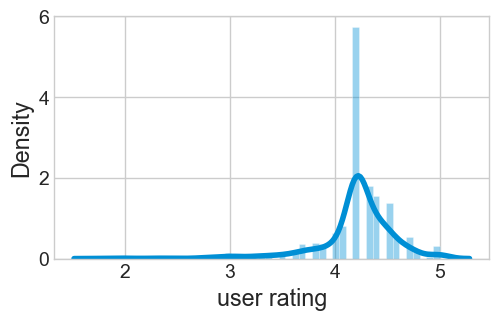

In [143]:
plt.figure(figsize=(5, 3))
sns.distplot(data["user rating"])
plt.show()

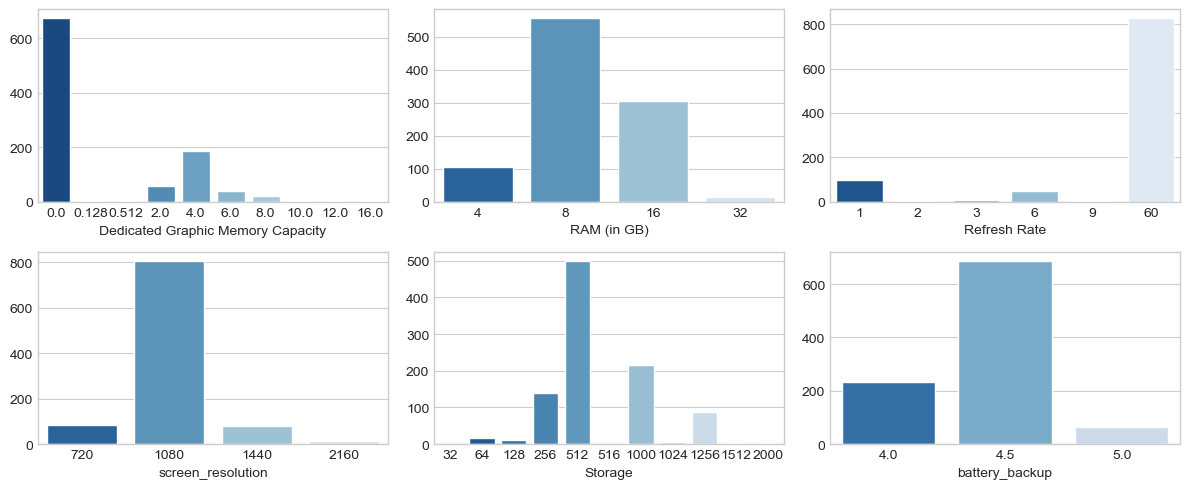

In [39]:
plt.figure(figsize=(12, 5))

for i, feature in enumerate(["Dedicated Graphic Memory Capacity", "RAM (in GB)", "Refresh Rate", "screen_resolution", "Storage", "battery_backup"]):
    plt.subplot(2, 3, i+1)
    counts = data[feature].value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")

plt.tight_layout()

In [150]:
data.drop(["Refresh Rate"], axis=1, inplace=True)
numerical_features.remove("Refresh Rate")
data['Storage'].replace(516, 512, inplace=True)
data['Storage'].replace(1000, 1024, inplace=True)
data['Storage'].replace(1256, 1280, inplace=True)
data['Storage'].replace(1512, 1536, inplace=True)
data['Storage'].replace(2000, 2048, inplace=True)

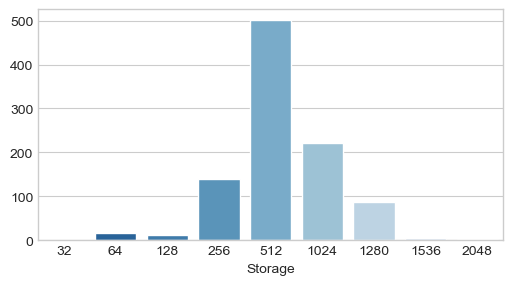

In [27]:
plt.figure(figsize=(6, 3))
counts = data["Storage"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

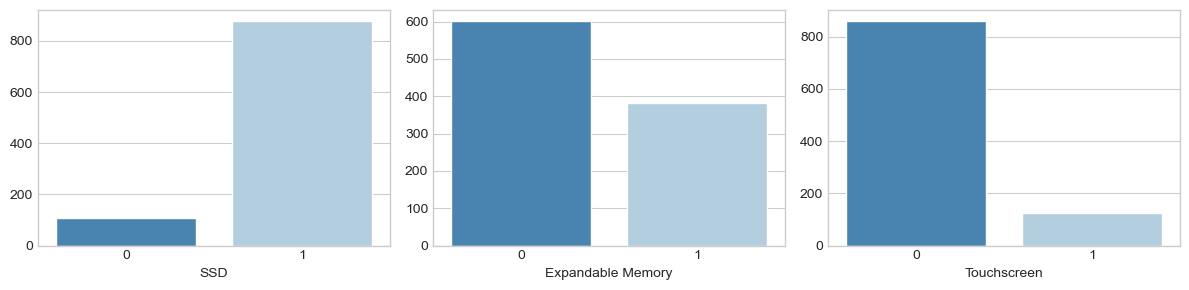

In [28]:
plt.figure(figsize=(12, 3))

for i, feature in enumerate(binary_features):
    plt.subplot(1, 3, i+1)
    counts = data[feature].value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")

plt.tight_layout()

In [43]:
for i, feature in enumerate(already_encoded_categorical_features):
    unique_values = data[feature].unique()
    print(f"{feature}: {len(unique_values)} unique values")
    print(unique_values)

Type: 4 unique values
[1 2 3 4]
Processor Brand: 5 unique values
[1 2 3 4 5]
Operating System: 5 unique values
[1 2 3 4 5]
company: 16 unique values
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [151]:
type_values = ["gaming laptop", "thin and light laptop", "2 in 1 laptop", "notebook"]
processor_brand_values = ["intel", "amd", "qualcomm", "apple", "mediatek"]
operating_system_values = ["windows", "chrome os", "dos", "mac", "ubuntu"]
company_values = ["asus", "hp", "lenovo", "dell", "msi", "realme", "avita", "acer", "samsung", "infinix", "lg",
                  "apple", "nokia", "redmibook", "mi", "vaio"]
values = [type_values, processor_brand_values, operating_system_values, company_values]

for feature, replace_values in zip(already_encoded_categorical_features, values):
    unique_values = data[feature].unique()
    for value in unique_values:
        data[feature].replace(value, replace_values[value-1], inplace=True)

In [45]:
for i, feature in enumerate(already_encoded_categorical_features):
    unique_values = data[feature].unique()
    print(f"{feature}: {len(unique_values)} unique values")
    print(unique_values)

Type: 4 unique values
['gaming laptop' 'thin and light laptop' '2 in 1 laptop' 'notebook']
Processor Brand: 5 unique values
['intel' 'amd' 'qualcomm' 'apple' 'mediatek']
Operating System: 5 unique values
['windows' 'chrome os' 'dos' 'mac' 'ubuntu']
company: 16 unique values
['asus' 'hp' 'lenovo' 'dell' 'msi' 'realme' 'avita' 'acer' 'samsung'
 'infinix' 'lg' 'apple' 'nokia' 'redmibook' 'mi' 'vaio']


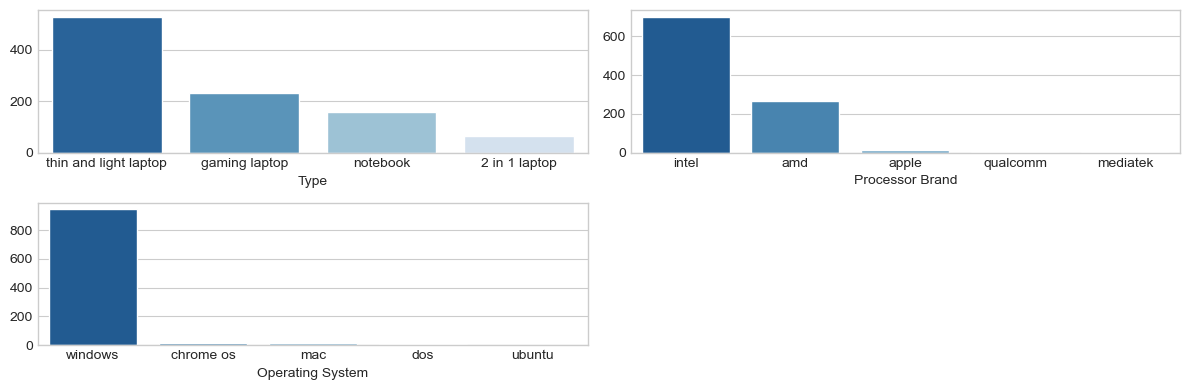

In [48]:
plt.figure(figsize=(12, 4))

for i, feature in enumerate(["Type", "Processor Brand", "Operating System"]):
    plt.subplot(2, 2, i+1)
    counts = data[feature].value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")

plt.tight_layout()

In [152]:
data['Operating System'].replace("chrome os", "other", inplace=True)
data['Operating System'].replace("mac", "other", inplace=True)
data['Operating System'].replace("dos", "other", inplace=True)
data['Operating System'].replace("ubuntu", "other", inplace=True)

data['Processor Brand'].replace("apple", "other", inplace=True)
data['Processor Brand'].replace("qualcomm", "other", inplace=True)
data['Processor Brand'].replace("mediatek", "other", inplace=True)

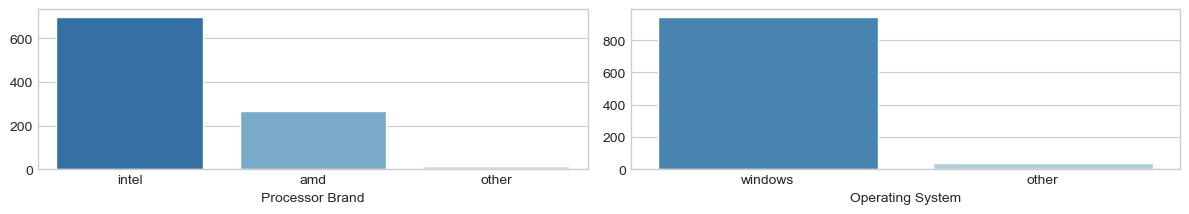

In [53]:
plt.figure(figsize=(12, 4))

for i, feature in enumerate(["Processor Brand", "Operating System"]):
    plt.subplot(2, 2, i+1)
    counts = data[feature].value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")

plt.tight_layout()

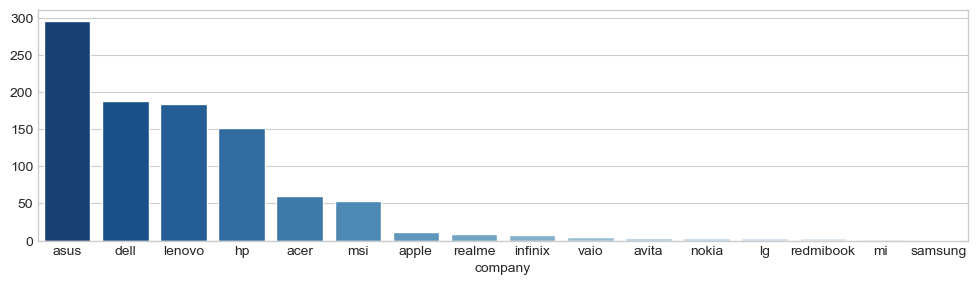

In [52]:
plt.figure(figsize=(12, 3))
counts = data["company"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

In [153]:
data['company'].replace("realme", "other", inplace=True)
data['company'].replace("infinix", "other", inplace=True)
data['company'].replace("vaio", "other", inplace=True)
data['company'].replace("avita", "other", inplace=True)
data['company'].replace("nokia", "other", inplace=True)
data['company'].replace("lg", "other", inplace=True)
data['company'].replace("redmibook", "other", inplace=True)
data['company'].replace("mi", "other", inplace=True)
data['company'].replace("samsung", "other", inplace=True)

In [57]:
plt.figure(figsize=(12, 3))
counts = data["company"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

In [58]:
for i, feature in enumerate(categorical_features):
    unique_values = data[feature].unique()
    print(f"{feature}: {len(unique_values)} unique values")
    print(unique_values)

RAM Type: 8 unique values
['ddr5' 'ddr4' 'lpddr4x' 'lpddr5' 'lpddr4' 'unified memory' 'ddr3'
 'lpddr3']
Processor name: 61 unique values
['intel core i9 12th gen' 'amd ryzen 7 octa core'
 'amd ryzen 7 octa core 5th gen' 'intel core i5 11th gen'
 'intel core i7 11th gen' 'intel celeron dual core'
 'intel core i5 10th gen' 'intel pentium silver' 'amd athlon dual core'
 'amd ryzen 7 dual core 7th gen' 'amd ryzen 3 quad core 3rd gen'
 'amd ryzen 9 octa core 5th gen' 'intel core i3 11th gen'
 'amd ryzen 5 hexa core' 'intel core i5 12th gen' 'intel core i7 12th gen'
 'amd ryzen 5 quad core' 'amd ryzen 7 hexa core 10th gen'
 'amd ryzen 9 octa core 10th gen' 'amd ryzen 7 quad core 10th gen'
 'intel core i3 10th gen' 'amd ryzen 5 quad core 3rd gen'
 'intel pentium quad core' 'intel celeron quad core'
 'amd ryzen 7 quad core' 'intel core i9 11th gen'
 'qualcomm snapdragon 7c gen 2' 'amd ryzen 5 dual core'
 'amd ryzen 3 dual core' 'intel pentium quad core 10th gen'
 'intel core i7 10th gen' 'amd 

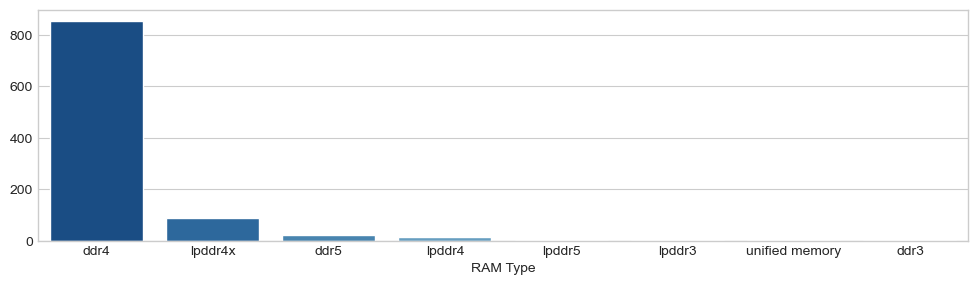

In [59]:
plt.figure(figsize=(12, 3))
counts = data["RAM Type"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

In [154]:
data['RAM Type'].replace("lpddr5", "other", inplace=True)
data['RAM Type'].replace("lpddr3", "other", inplace=True)
data['RAM Type'].replace("unified memory", "other", inplace=True)
data['RAM Type'].replace("ddr3", "other", inplace=True)

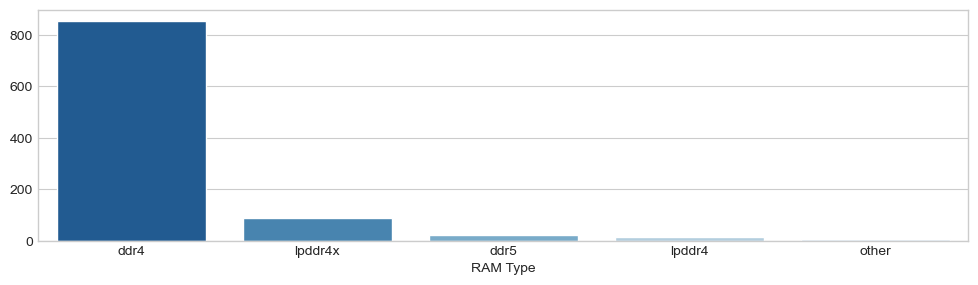

In [61]:
plt.figure(figsize=(12, 3))
counts = data["RAM Type"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

In [155]:
data.drop(["Processor name"], axis=1, inplace=True)
categorical_features.remove("Processor name")

In [156]:
data['gpu name '] = data['gpu name '].apply(lambda x: x.split()[0])

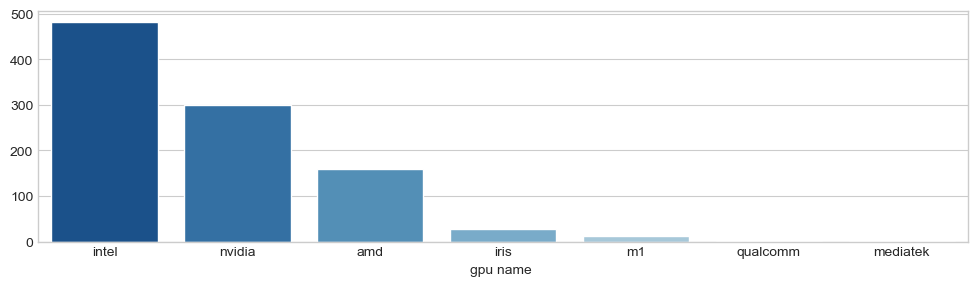

In [68]:
plt.figure(figsize=(12, 3))
counts = data['gpu name '].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

In [157]:
data['gpu name '].replace("iris", "intel", inplace=True)
data['gpu name '].replace("m1", "other", inplace=True)
data['gpu name '].replace("qualcomm", "other", inplace=True)
data['gpu name '].replace("mediatek", "other", inplace=True)

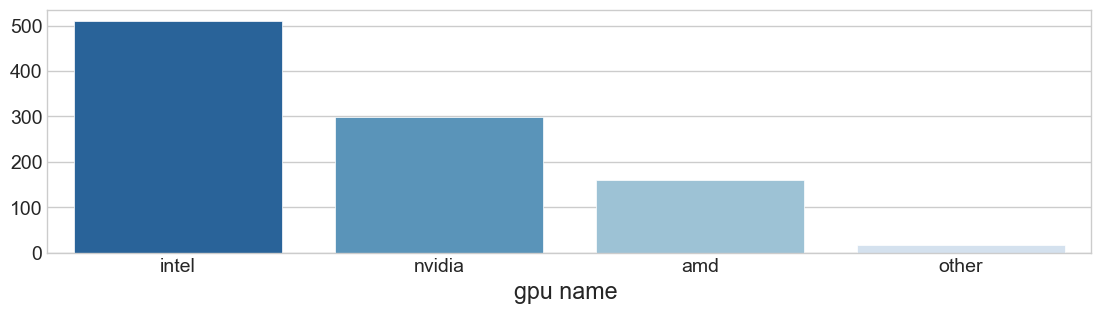

In [158]:
plt.figure(figsize=(12, 3))
counts = data['gpu name '].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="Blues_r")
plt.show()

In [159]:
categorical_features = categorical_features + already_encoded_categorical_features
encoder = OneHotEncoder(sparse=False)
one_hot_encoded = encoder.fit_transform(data[categorical_features])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))

data = pd.concat([data, one_hot_df], axis=1)
data.drop(categorical_features, axis=1, inplace=True)

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user rating                        984 non-null    float64
 1   Price (in Indian Rupees)           984 non-null    int64  
 2   Dedicated Graphic Memory Capacity  984 non-null    float64
 3   SSD                                984 non-null    int64  
 4   RAM (in GB)                        984 non-null    int64  
 5   Expandable Memory                  984 non-null    int64  
 6   Touchscreen                        984 non-null    int64  
 7   Screen Size (in inch)              984 non-null    float64
 8   Weight (in kg)                     984 non-null    float64
 9   screen_resolution                  984 non-null    int64  
 10  Storage                            984 non-null    int64  
 11  CPU_ranking                        984 non-null    int64  

[]

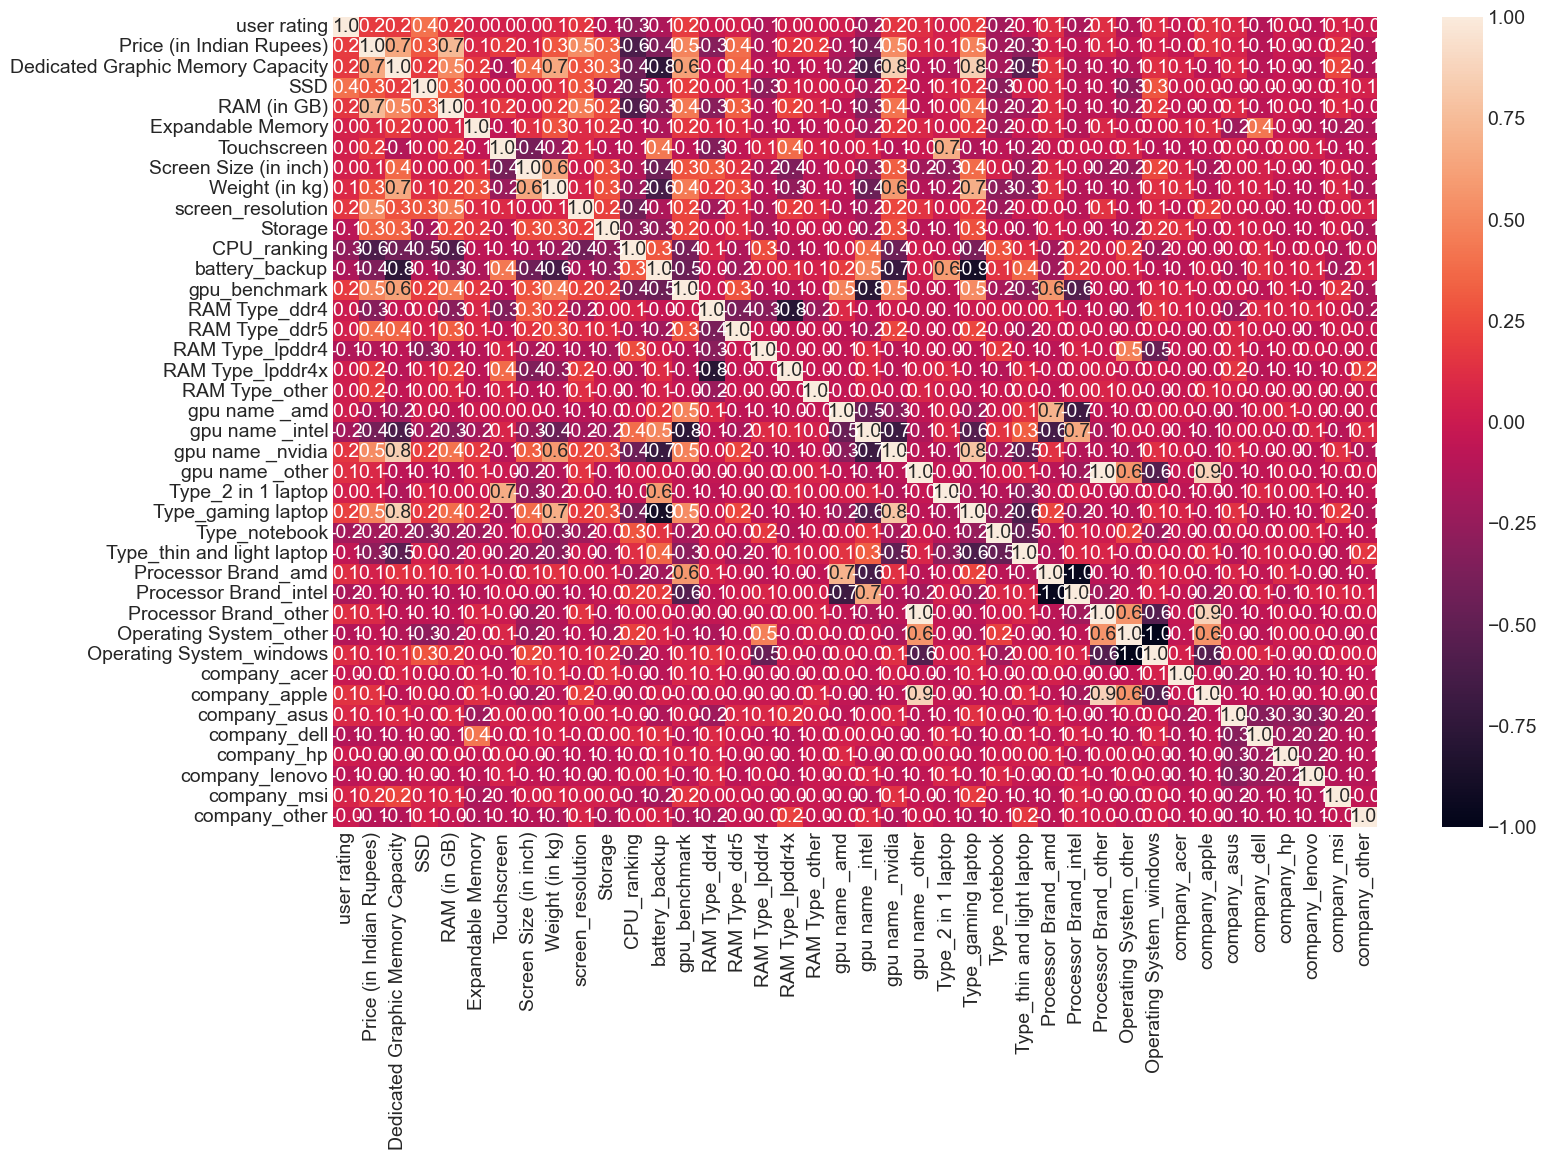

In [160]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot = True, fmt='.1f')
plt.plot()

In [161]:
data.drop(["gpu name _other"], axis=1, inplace=True)
data.drop(["Operating System_other"], axis=1, inplace=True)
data.drop(["Processor Brand_amd", "Processor Brand_other"], axis=1, inplace=True)

[]

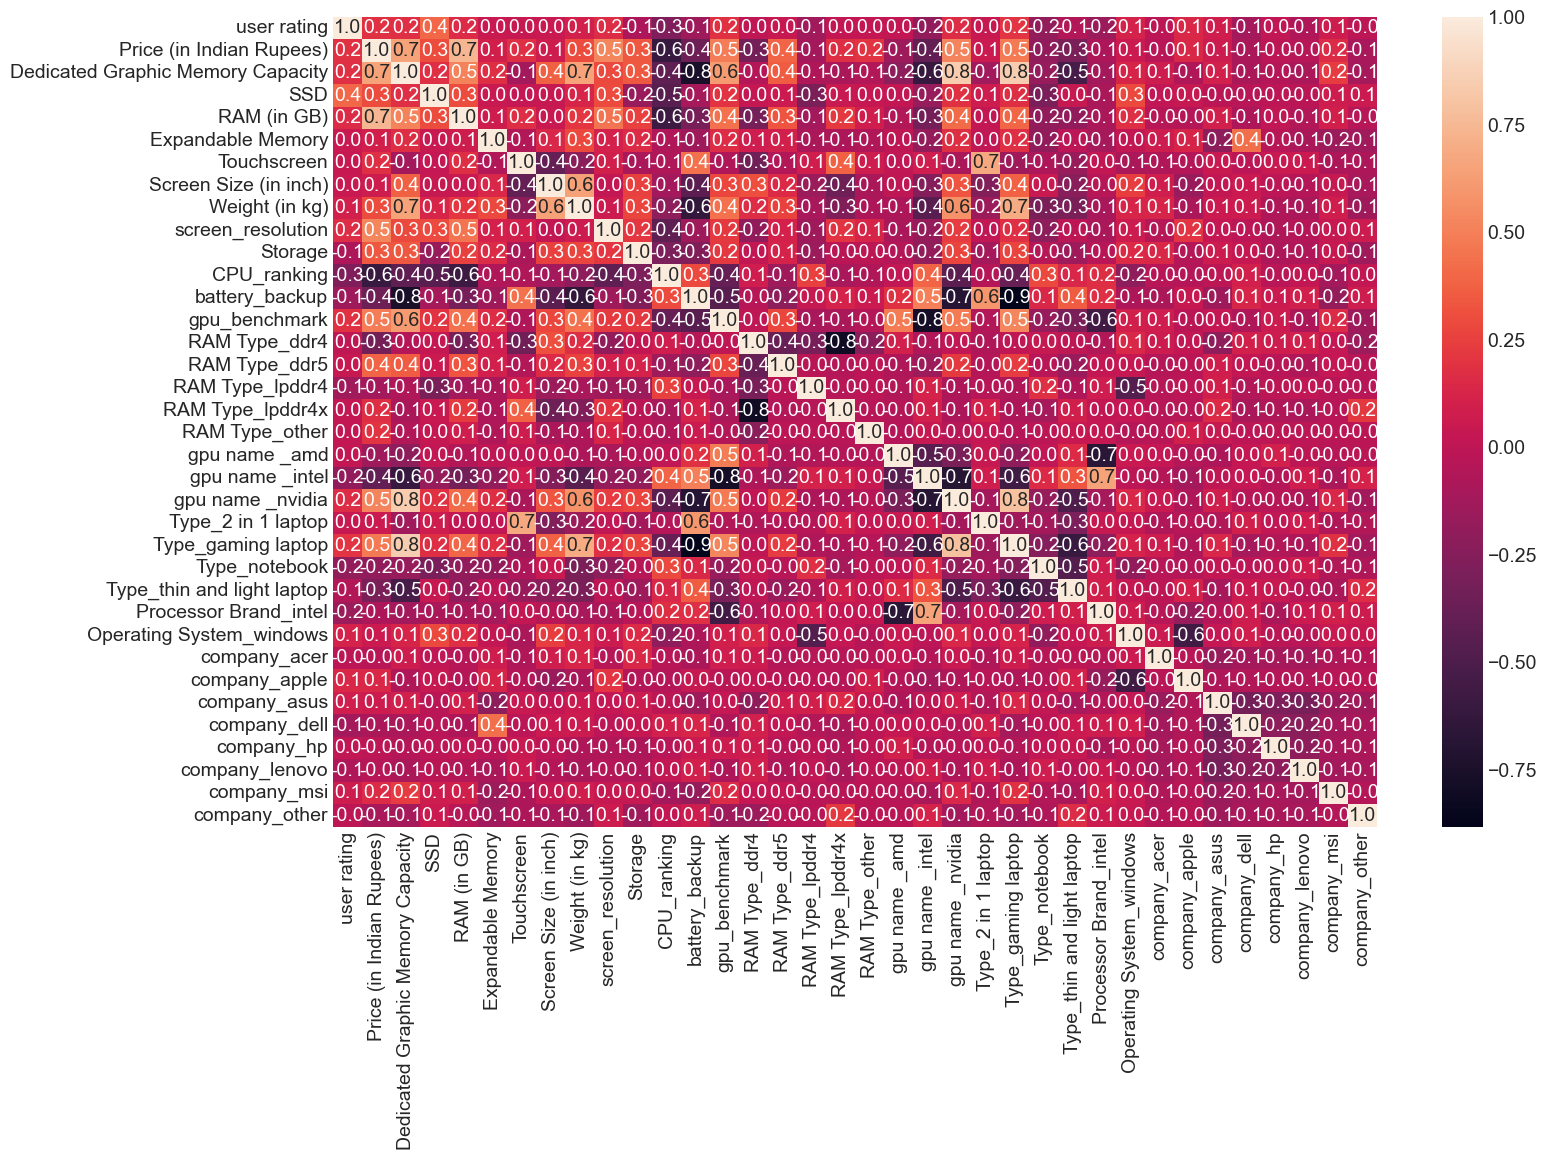

In [210]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot = True, fmt='.1f')
plt.plot()

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user rating                        984 non-null    float64
 1   Price (in Indian Rupees)           984 non-null    int64  
 2   Dedicated Graphic Memory Capacity  984 non-null    float64
 3   SSD                                984 non-null    int64  
 4   RAM (in GB)                        984 non-null    int64  
 5   Expandable Memory                  984 non-null    int64  
 6   Touchscreen                        984 non-null    int64  
 7   Screen Size (in inch)              984 non-null    float64
 8   Weight (in kg)                     984 non-null    float64
 9   screen_resolution                  984 non-null    int64  
 10  Storage                            984 non-null    int64  
 11  CPU_ranking                        984 non-null    int64  

### Clustering

In [164]:
data_numerical = data[numerical_features + binary_features]
data_with_categorical_features = data

In [165]:
scaler = StandardScaler()
scaled_features_numerical = scaler.fit_transform(data_numerical)
scaled_features_with_categorical = scaler.fit_transform(data_with_categorical_features)

In [ ]:
def visualize_clusters(features, clusters):
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(features)
    pc1_values = pcs[:,0]
    pc2_values = pcs[:,1]

    pca = PCA(n_components=3)
    pcs = pca.fit_transform(features)
    pc1_values = pcs[:,0]
    pc2_values = pcs[:,1]
    pc3_values = pcs[:,2]

    fig = plt.figure(figsize=(13, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=pc1_values, y=pc2_values, hue=clusters, c=clusters.astype(float), alpha=0.8, cmap="viridis")

    ax = fig.add_subplot(1, 2, 2, projection="3d", elev=48, azim=134)
    ax.scatter(pc1_values, pc2_values, pc3_values, c=clusters.astype(float), cmap="viridis")

    plt.show()

#### K-means

In [226]:
def do_elbow_method(kmeans_kwargs, features):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)

    return sse

def do_silhouette_score(kmeans_kwargs, features):
    silhouette_coefficients = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_coefficients.append(score)

    return silhouette_coefficients

def visualize_k(sse, silhouette_coefficients):
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")

    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")

    plt.show()

def do_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters)
    clusters = kmeans.fit_predict(X)
    print(kmeans.cluster_centers_)
    
    return clusters

##### Numerical features

In [232]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
# init='k-means++'

sse = do_elbow_method(kmeans_kwargs, scaled_features_numerical)
silhouette_coefficients = do_silhouette_score(kmeans_kwargs, scaled_features_numerical)
visualize_k(sse, silhouette_coefficients)

k = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(f"k = {k.elbow}")

k = 4


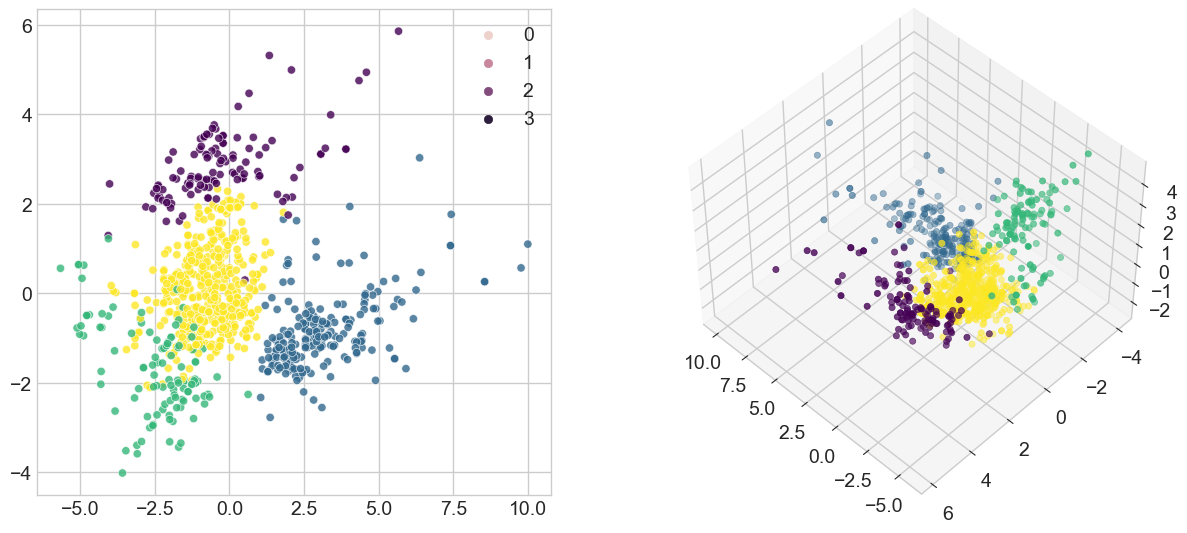

In [240]:
clusters = do_kmeans(scaled_features_numerical, 4)
visualize_clusters(scaled_features_numerical, clusters)

In [241]:
kmeans_silhouette = silhouette_score(scaled_features_numerical, clusters).round(2)
print(kmeans_silhouette)

0.27


##### Numerical + categorical features

In [233]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

sse = do_elbow_method(kmeans_kwargs, scaled_features_with_categorical)
silhouette_coefficients = do_silhouette_score(kmeans_kwargs, scaled_features_with_categorical)
visualize_k(sse, silhouette_coefficients)

k = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(f"k = {k.elbow}")

k = 3


In [237]:
clusters = do_kmeans(scaled_features_with_categorical, 3)
visualize_clusters(scaled_features_with_categorical, clusters)

In [239]:
kmeans_silhouette = silhouette_score(scaled_features_with_categorical, clusters).round(2)
print(kmeans_silhouette)

0.18


#### Agglomerative Hierarchical Clustering

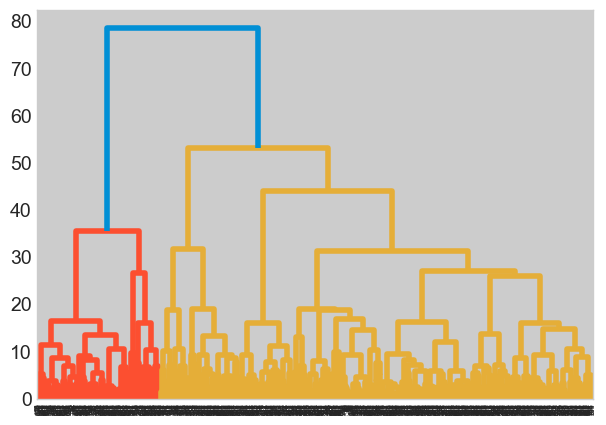

In [242]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(scaled_features_numerical, method='ward'))

In [192]:
def doAgglomerative(X, nclust):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
    clusters = model.fit_predict(X)
    
    return clusters

# number of clusters or distance threshold, linkage type, distance

##### Numerical features

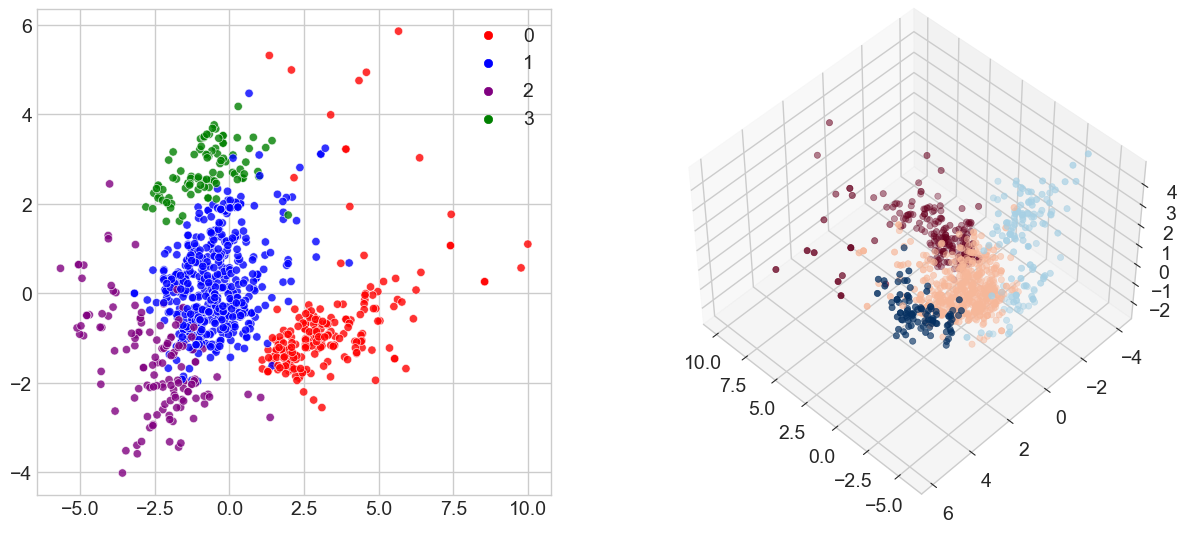

In [218]:
clusters = doAgglomerative(scaled_features_numerical, 4)
visualize_clusters(scaled_features_numerical, clusters)

##### Numerical + categorical features

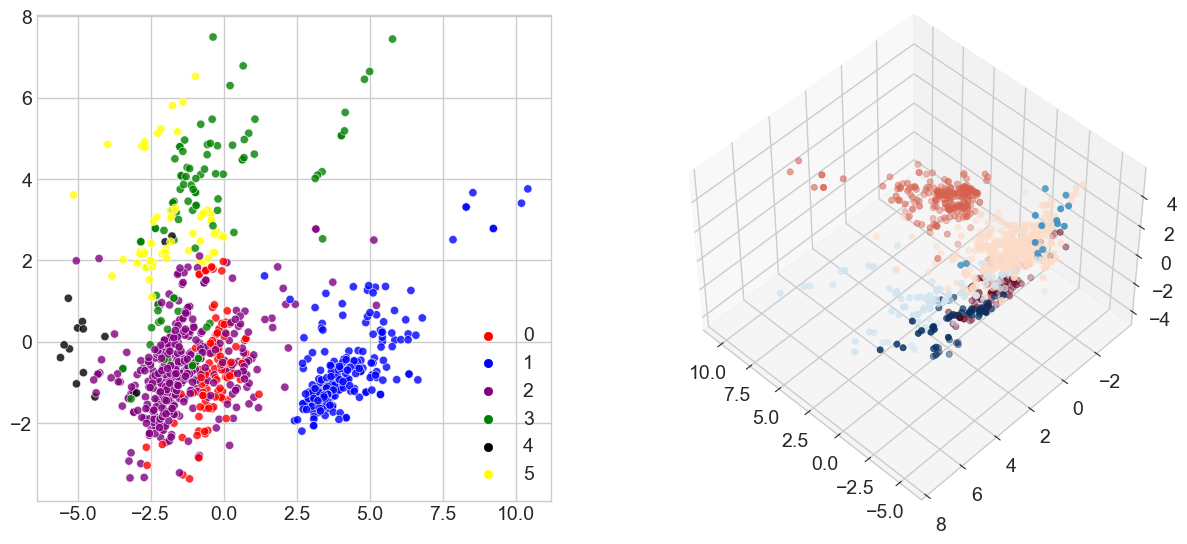

In [219]:
clusters = doAgglomerative(scaled_features_with_categorical, 6)
visualize_clusters(scaled_features_with_categorical, clusters)

#### GaussianMixture

In [196]:
def doGMM(X, nclust):
    model = GaussianMixture(n_components=nclust, init_params='kmeans')
    clusters = model.fit_predict(X)
    
    return clusters

##### Numerical features

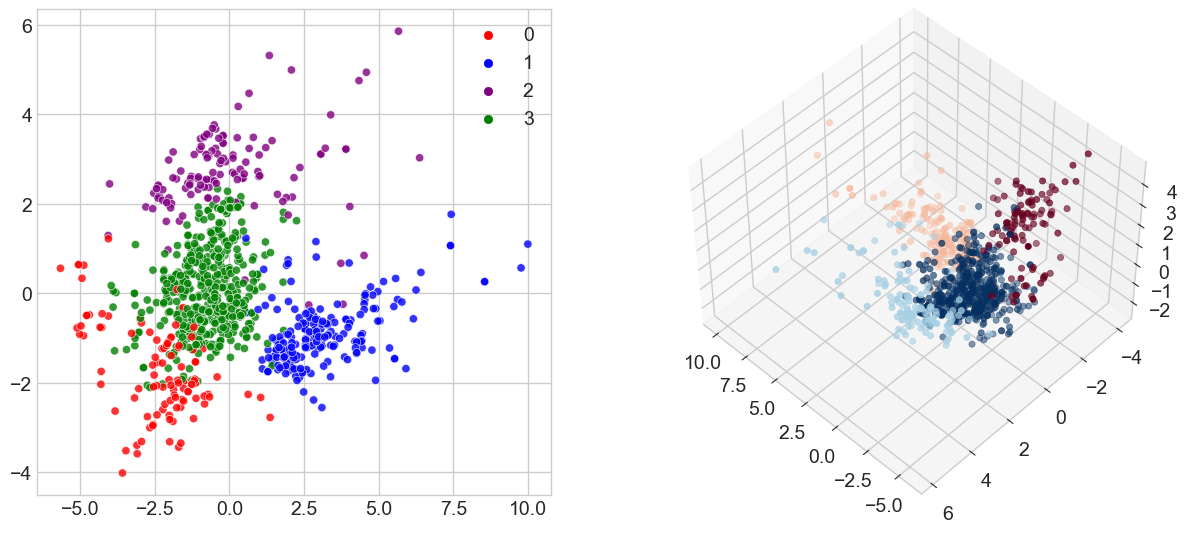

In [220]:
clusters = doGMM(scaled_features_numerical, 4)
visualize_clusters(scaled_features_numerical, clusters)

##### Numerical + categorical features

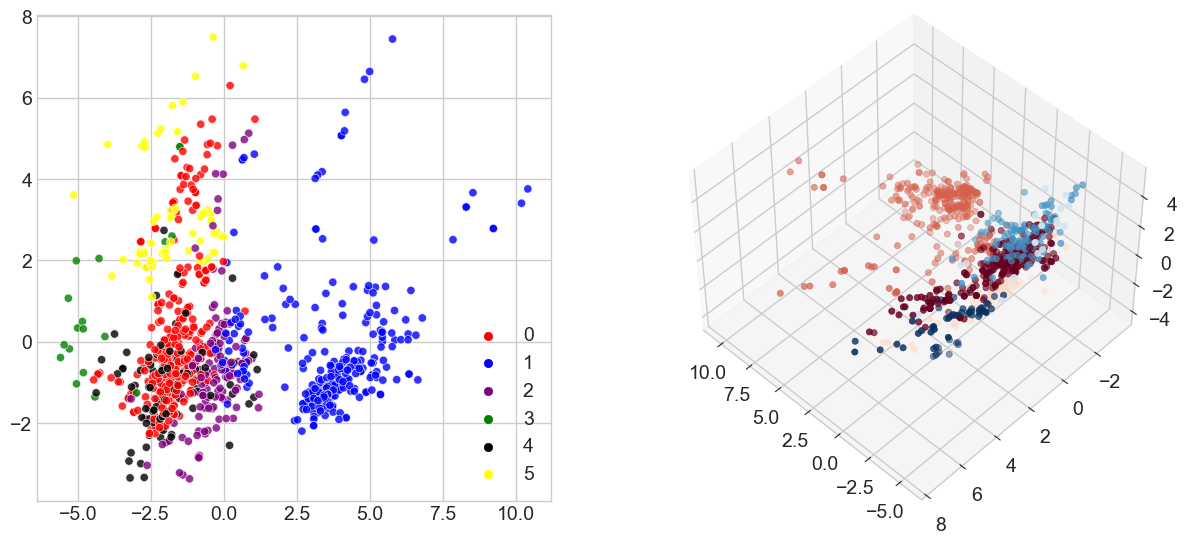

In [221]:
clusters = doGMM(scaled_features_with_categorical, 6)
visualize_clusters(scaled_features_with_categorical, clusters)

#### DBSCAN

In [199]:
def doDBScan(X):
    model = DBSCAN(eps=3.2, min_samples=2)
    clusters = model.fit_predict(X)
    
    return clusters

##### Numerical features

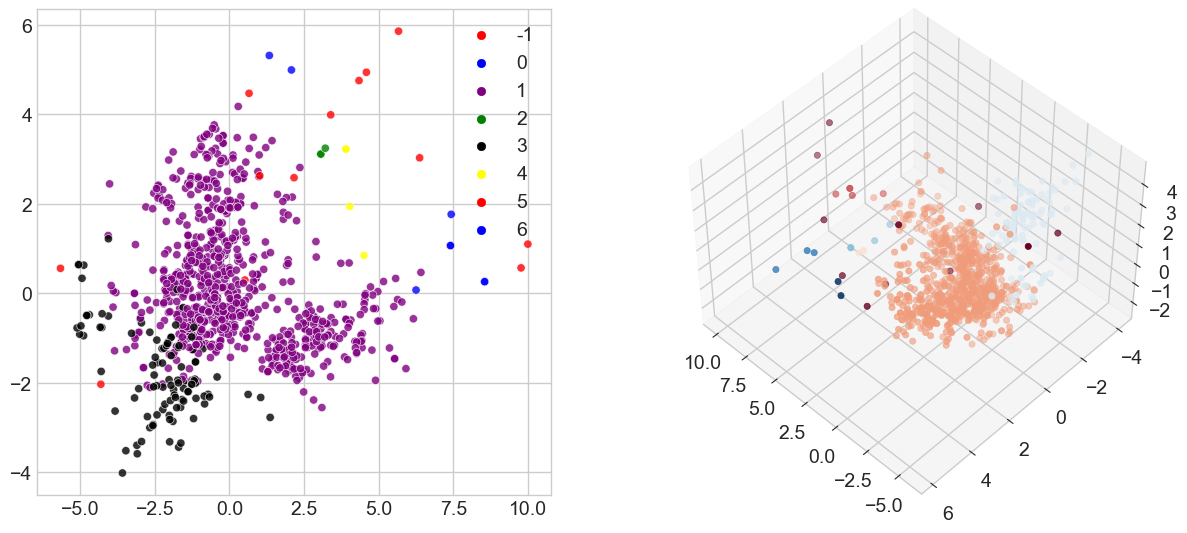

In [222]:
clusters = doDBScan(scaled_features_numerical)
visualize_clusters(scaled_features_numerical, clusters)

##### Numerical + categorical features

In [223]:
clusters = doDBScan(scaled_features_with_categorical)
visualize_clusters(scaled_features_with_categorical, clusters)

#### HDBSCAN

In [ ]:
# minimum cluster membership, minimum point neighbors

#### OPTICS

In [ ]:
# minimum cluster membership

#### BIRCH

In [ ]:
# branching factor, threshold, optional global clusterer.

#### Spectral clustering

#### Mean Shift

In [ ]:
# bandwidth

#### Affinity Propagation

In [ ]:
def doAffinity(X):
    model = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
    model.fit(X)
    clusters = model.predict(X)
    centers = model.cluster_centers_

    return (clusters, centers)

##### Numerical features

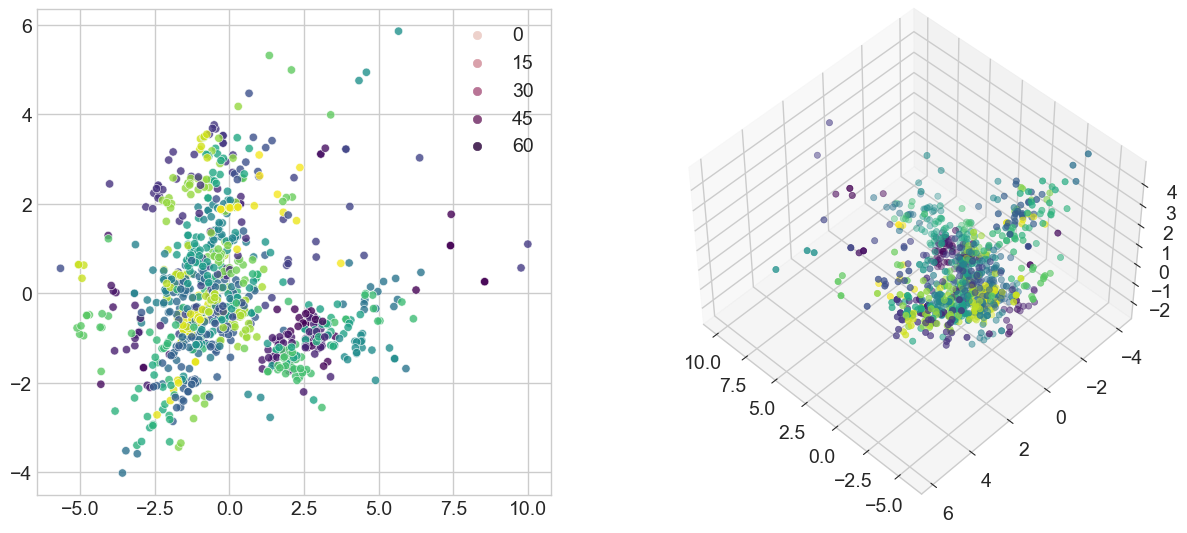

In [245]:
clusters, centers = doAffinity(scaled_features_numerical)
visualize_clusters(scaled_features_numerical, clusters)

##### Numerical + categorical features

In [246]:
clusters, centers = doAffinity(scaled_features_numerical)
visualize_clusters(scaled_features_numerical, clusters)